# Synergistic causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

This tutorial explains how to deal with synergistic dependencies.

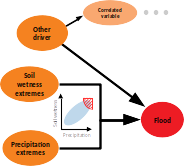

The following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
import sys
sys.path.append('./../')
sys.path.append('./../../')

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, ParCorrMult, ParCorrWLS, GPDC, CMIknn, CMIknnMixed, CMIsymb, Gsquared, RegressionCI

In [2]:
np.random.seed(1)

# Toy model data

This synthetic data considers five discrete variables where variables soil moisture and precipitation cause flood extremes by an AND-operation. There is also another driver of floods and that one also causes another variable.

In [3]:
def synergistic_data(T, p=0.2, snr=0.8, seed=1):
#     random_state = np.random.default_rng(seed)
    
    syn1 = np.random.binomial(n=1, p=p, size=(T, 1))
    syn2 = np.random.binomial(n=1, p=p, size=(T, 1))
    
    other_driver = np.random.binomial(n=1, p=p, size=(T, 1))
    corr_noise = np.random.binomial(n=1, p=p, size=(T, 1))
    flood_noise = np.random.binomial(n=1, p=p, size=(T, 1))
    
    # floods are driven by precipitation and soil wetness extremes, but also by other drivers
    flood = np.mod(np.logical_and(syn1, syn2) + other_driver + flood_noise, 2)
    corr = np.mod(other_driver + corr_noise, 2)

    # Linear version
#     syn1 = np.expand_dims(np.random.randn(T), axis = -1)
#     syn2 = np.expand_dims(np.random.randn(T), axis = -1)
#     other_driver = np.expand_dims(np.random.randn(T), axis = -1)
#     flood = syn1 + syn2 + other_driver + np.expand_dims(np.random.randn(T), axis = -1)
#     corr = other_driver + np.expand_dims(np.random.randn(T), axis = -1)

    data = np.concatenate([syn1, syn2, flood, other_driver, corr], axis=-1)
    return data

In [4]:
var_names = ['soil', 'precip', 'flood', 'othercause', 'corr']

# Causal analysis based on Tigramite and the PC algorithm 

The PC algorithm is a causal discovery algorithm, here initiated with a ``CMIsymb`` conditional independence test for categorical/discrete data.

In [13]:
def run_pcmci_cmi(dataframe, sig_samples=100):
#     ci_test = CMIknnMixed(sig_samples=sig_samples, estimator='MS')
#     ci_test = ParCorrMult()
    ci_test = CMIsymb(sig_samples=sig_samples)

    pcmci_cmi = PCMCI(
        dataframe=dataframe, 
        cond_ind_test=ci_test)
    results = pcmci_cmi.run_pcalg_non_timeseries_data(pc_alpha=0.01)
    val_matrix = results['val_matrix']
    # val_matrix /= (2.*T)
    
    return val_matrix, results

In [14]:
def plot(val_matrix, val_results, var_names, node_pos):
    tp.plot_graph(
    val_matrix=val_matrix,
    graph=val_results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmin_edges=0.,
    vmax_edges = 0.3,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.5,
    node_ticks=.1,
    cmap_nodes='OrRd',
    node_pos = node_pos,
    ); plt.show()

Plot the data.

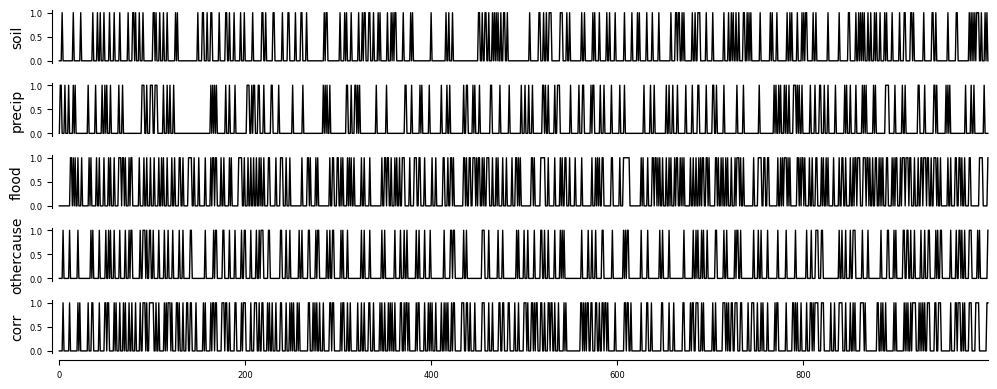

In [15]:
T = 1000
data = synergistic_data(T, p=0.2, snr=0.8)
single_dataframe = pp.DataFrame(data, 
                             var_names=var_names, 
#                              type_mask=np.ones(data.shape)
                               )
tp.plot_timeseries(single_dataframe, figsize=(10,4)); plt.show()

# Single-variable-mode of Tigramite

We first show how a causal analysis that treats soil moisture and precipitation as individual variables fails.

In [16]:
single_matrix, single_results = run_pcmci_cmi(single_dataframe, sig_samples=200)

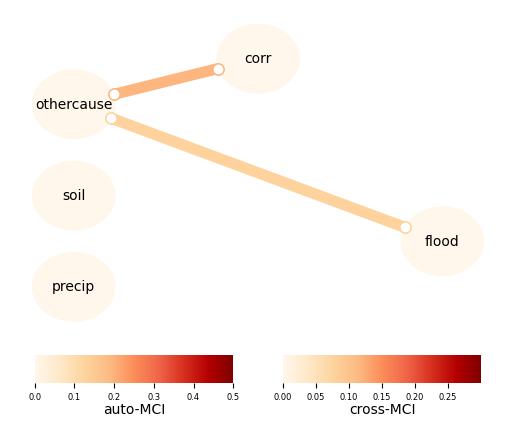

In [17]:
node_pos = {'x':np.array([0., 0., 1., 0., 0.5]), 'y':np.array([0.4, 0., 0.2, 0.8, 1. ])}
plot(single_matrix, single_results, var_names, node_pos)

This fails to detect that both soil moisture and precipitation cause floods.

# Synergistic-mode of Tigramite

This uses the ``vector_vars`` parameter to define soil moisture and precipitation as a joint variable while the others stay one-dimensional.

In [18]:
# twos_data = get_two_var_data(T, p=0.2, snr=0.8)
var_names_joint = ['soil&precip', 'flood', 'othercause', 'corr']
joint_dataframe = pp.DataFrame(data, 
#                               type_mask=np.ones(data.shape), 
                              var_names=var_names_joint, 
                              vector_vars={0: [(0, 0), (1, 0)], 1: [(2, 0)], 2: [(3, 0)], 3: [(4, 0)]}
#                               vector_vars={0: [(0, 0), (1, 0)], 1: [(2, 0)]}
                              )


In [19]:
syn_matrix, syn_results = run_pcmci_cmi(joint_dataframe, sig_samples=200)

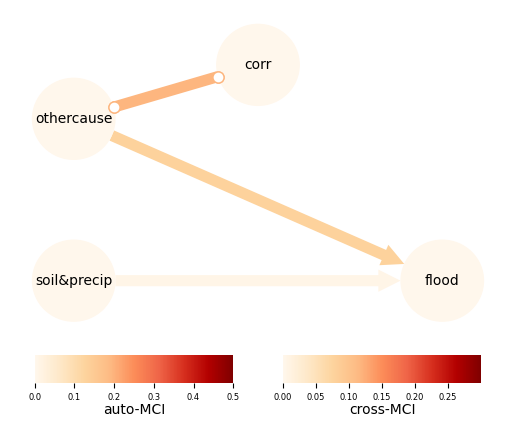

In [20]:
node_pos_joint = {'x':np.array([0., 1., 0., 0.5]), 'y':np.array([0.2, 0.2, 0.8, 1. ])}

plot(syn_matrix, syn_results, var_names_joint, node_pos=node_pos_joint)

Now we get the correct result.